# Image Captioning

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import spacy
import re
import random
import json

from PIL import Image
from data_preprocessing import *
import urllib.request
import io

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
extracted_data_train_dir = 'extracted_data/train/'
extracted_data_test_dir = 'extracted_data/test/'

In [3]:
def load_json(file):
    with open(file, 'r') as f1:
        return json.loads(f1.read())

In [4]:
train_captions = load_json(extracted_data_train_dir + 'captions.json')
train_image_paths = load_json(extracted_data_train_dir + 'image_paths.json')

In [5]:
train_captions[55]

'<START> A bathroom with a TV near the mirror <END>'

In [6]:
train_image_paths[55]

'mscoco/train/img/COCO_train2014_000000028149'

In [7]:
# train_captions = [x[8:] for x in train_captions]

In [8]:
print(train_image_paths[0], train_captions[0])

mscoco/train/img/COCO_train2014_000000318556 <START> A very clean and well decorated empty bathroom <END>


## Building a vocabulary

In [9]:
from Vocabulary import Vocabulary

In [10]:
max_vocab_size = 5000

In [11]:
train_vocab = Vocabulary(train_captions, max_vocab_size)

In [12]:
gfdx = Vocabulary(train_captions, max_vocab_size)

In [13]:
print(train_vocab.encoded_captions[0])
print(train_vocab.decode_sentence(train_vocab.encoded_captions[0]))
print(train_captions[0])

[1, 4, 145, 430, 10, 667, 450, 237, 35, 2]
<start> a very clean and well decorated empty bathroom <end>
<START> A very clean and well decorated empty bathroom <END>


Create encoded captions for each caption in training

In [14]:
encoded_captions_train = [train_vocab.encode_sentence(x) for x in train_captions]

print(encoded_captions_train[:1])
print(train_vocab.decode_sentence(encoded_captions_train[0]))
print(train_captions[:1])

[[1, 4, 145, 430, 10, 667, 450, 237, 35, 2]]
<start> a very clean and well decorated empty bathroom <end>
['<START> A very clean and well decorated empty bathroom <END>']


In [15]:
len(encoded_captions_train)

249454

## Create Dataset

In [16]:
from torch.utils.data import DataLoader
from MyDataset import MyDataset

In [17]:
from torch.nn.utils.rnn import pad_sequence
wat = [torch.tensor(x[1:], dtype=torch.int16) for x in train_vocab.encoded_captions]
# wat = [torch.tensor(x, dtype=torch.int16) for x in train_vocab.encoded_captions]
padded = pad_sequence(wat).permute(1, 0)
print(len(padded))

249454


In [18]:
encoded_captions_train[55]

[1, 4, 35, 9, 4, 397, 31, 5, 140, 2]

In [19]:
train_vocab.encoded_captions[55]

[1, 4, 35, 9, 4, 397, 31, 5, 140, 2]

In [20]:
padded.shape

torch.Size([249454, 50])

In [21]:
padded[0]

tensor([  4, 145, 430,  10, 667, 450, 237,  35,   2,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0], dtype=torch.int16)

In [22]:
dataset = MyDataset(enc_captions=padded,
                    image_paths=train_image_paths,
                   data_dir=extracted_data_train_dir + 'vecs/')

In [23]:
# small dataste
dataset = MyDataset(enc_captions=padded[:256],
                    image_paths=train_image_paths[:256],
                   data_dir=extracted_data_train_dir + 'vecs/')

In [24]:
x = dataset[1]

In [25]:
dataset[0][0].shape

torch.Size([64, 2048])

In [26]:
dataloader = DataLoader(dataset=dataset, batch_size=256, 
                         num_workers = 0)

In [27]:
for idx, data in enumerate(dataloader):
    imgs, labels = data[0], data[1]
    print(idx, imgs.shape)
    print(labels[0].shape)
    print(labels[0].tolist())
    print(train_vocab.decode_sentence(labels[0].tolist()))
    break

0 torch.Size([256, 64, 2048])
torch.Size([50])
[4, 145, 430, 10, 667, 450, 237, 35, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
a very clean and well decorated empty bathroom <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


## Train model

In [28]:
from layers.Encoder import Encoder
from layers.Decoder import Decoder
from layers.Attention import Attention
from layers.End2End import End2End

In [74]:
DEC_EMB_DIM = 512
ENC_INPUT = 2048
ENC_OUTPUT = 256 
DEC_HID_DIM = 512
DEC_OUTPUT = 512
ATTN_DIM = 512
EMB_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [75]:
PAD_IDX = 0

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [76]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [77]:
model = None
torch.cuda.empty_cache()

In [78]:
torch.cuda.empty_cache()
model = End2End(ENC_INPUT, ENC_OUTPUT, DEC_HID_DIM, DEC_OUTPUT,
               EMB_DIM, ATTN_DIM, train_vocab, criterion, device)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,128,201 trainable parameters


In [79]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.Adam(model.parameters(), lr=0.00025)

In [80]:
# optimizer.lr = 0.001

In [81]:
loss_plot = []

def train_step(batch, captions):
    
    batch_size = captions.shape[0]
    caption_length = captions.shape[1]
    
    optimizer.zero_grad()
    out, loss = model(batch, captions)
#     ww = out[0]
#     ww = torch.max(ww, dim=1)[1]
#     print(train_vocab.decode_sentence(ww.tolist()))
    
    loss.backward()
    optimizer.step()
    total_loss = loss / int(caption_length)
    return loss, total_loss

In [ ]:
import time

EPOCHS = 500

def train():
    model.train()
    for epoch in range(EPOCHS):
        start = time.time()
        total_loss = 0
        
        steps = 0
        for idx, batch in enumerate(dataloader):
            img_tensor, target, _ = batch[0], batch[1], batch[2]
            
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss.item()
            
            if idx % 500 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, idx, batch_loss.item() / int(target.shape[1])))
            steps += 1
            
        if epoch == 0:
            dataloader.dataset.set_use_cache(True)
            dataloader.num_workers = 3

        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / steps)
        
        if epoch % 100 == 0 and epoch > 0:
            torch.save(model.state_dict(), 'model')

        print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                             total_loss/steps))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

train()

Epoch 1 Batch 0 Loss 3.2354
Epoch 1 Loss 3.235376
Time taken for 1 epoch 3.7582223415374756 sec

Epoch 2 Batch 0 Loss 3.2176
Epoch 2 Loss 3.217591
Time taken for 1 epoch 3.65273118019104 sec

Epoch 3 Batch 0 Loss 3.1994
Epoch 3 Loss 3.199425
Time taken for 1 epoch 3.5865771770477295 sec

Epoch 4 Batch 0 Loss 3.1799
Epoch 4 Loss 3.179932
Time taken for 1 epoch 3.5758872032165527 sec

Epoch 5 Batch 0 Loss 3.1583
Epoch 5 Loss 3.158252
Time taken for 1 epoch 3.4938254356384277 sec

Epoch 6 Batch 0 Loss 3.1336
Epoch 6 Loss 3.133575
Time taken for 1 epoch 3.5477232933044434 sec

Epoch 7 Batch 0 Loss 3.1051
Epoch 7 Loss 3.105094
Time taken for 1 epoch 3.482170820236206 sec

Epoch 8 Batch 0 Loss 3.0720
Epoch 8 Loss 3.072006
Time taken for 1 epoch 3.5930233001708984 sec

Epoch 9 Batch 0 Loss 3.0335
Epoch 9 Loss 3.033530
Time taken for 1 epoch 3.5585713386535645 sec

Epoch 10 Batch 0 Loss 2.9889
Epoch 10 Loss 2.988914
Time taken for 1 epoch 3.490849256515503 sec

Epoch 11 Batch 0 Loss 2.9375
Epo

Epoch 85 Batch 0 Loss 1.4192
Epoch 85 Loss 1.419189
Time taken for 1 epoch 3.5756654739379883 sec

Epoch 86 Batch 0 Loss 1.4162
Epoch 86 Loss 1.416173
Time taken for 1 epoch 3.506721019744873 sec

Epoch 87 Batch 0 Loss 1.4125
Epoch 87 Loss 1.412550
Time taken for 1 epoch 3.513664722442627 sec

Epoch 88 Batch 0 Loss 1.4092
Epoch 88 Loss 1.409213
Time taken for 1 epoch 3.5359861850738525 sec

Epoch 89 Batch 0 Loss 1.4059
Epoch 89 Loss 1.405921
Time taken for 1 epoch 3.5821120738983154 sec

Epoch 90 Batch 0 Loss 1.4025
Epoch 90 Loss 1.402519
Time taken for 1 epoch 3.5714352130889893 sec

Epoch 91 Batch 0 Loss 1.3992
Epoch 91 Loss 1.399165
Time taken for 1 epoch 3.6099140644073486 sec

Epoch 92 Batch 0 Loss 1.3959
Epoch 92 Loss 1.395854
Time taken for 1 epoch 3.57269024848938 sec

Epoch 93 Batch 0 Loss 1.3926
Epoch 93 Loss 1.392551
Time taken for 1 epoch 3.490795373916626 sec

Epoch 94 Batch 0 Loss 1.3893
Epoch 94 Loss 1.389296
Time taken for 1 epoch 3.7572009563446045 sec

Epoch 95 Batch 

Epoch 167 Batch 0 Loss 1.1509
Epoch 167 Loss 1.150938
Time taken for 1 epoch 3.610384464263916 sec

Epoch 168 Batch 0 Loss 1.1480
Epoch 168 Loss 1.148008
Time taken for 1 epoch 3.720496892929077 sec

Epoch 169 Batch 0 Loss 1.1454
Epoch 169 Loss 1.145411
Time taken for 1 epoch 3.5388600826263428 sec

Epoch 170 Batch 0 Loss 1.1422
Epoch 170 Loss 1.142240
Time taken for 1 epoch 3.603755235671997 sec

Epoch 171 Batch 0 Loss 1.1393
Epoch 171 Loss 1.139310
Time taken for 1 epoch 3.8430092334747314 sec

Epoch 172 Batch 0 Loss 1.1364
Epoch 172 Loss 1.136375
Time taken for 1 epoch 3.799360990524292 sec

Epoch 173 Batch 0 Loss 1.1357
Epoch 173 Loss 1.135685
Time taken for 1 epoch 4.051825761795044 sec

Epoch 174 Batch 0 Loss 1.1327
Epoch 174 Loss 1.132744
Time taken for 1 epoch 4.3018083572387695 sec

Epoch 175 Batch 0 Loss 1.1292
Epoch 175 Loss 1.129157
Time taken for 1 epoch 4.447137117385864 sec

Epoch 176 Batch 0 Loss 1.1318
Epoch 176 Loss 1.131752
Time taken for 1 epoch 3.933281421661377 se

Epoch 249 Batch 0 Loss 0.9620
Epoch 249 Loss 0.961982
Time taken for 1 epoch 3.535984754562378 sec

Epoch 250 Batch 0 Loss 0.9600
Epoch 250 Loss 0.960032
Time taken for 1 epoch 3.5890562534332275 sec

Epoch 251 Batch 0 Loss 0.9582
Epoch 251 Loss 0.958186
Time taken for 1 epoch 3.4774951934814453 sec

Epoch 252 Batch 0 Loss 0.9556
Epoch 252 Loss 0.955601
Time taken for 1 epoch 3.5468976497650146 sec

Epoch 253 Batch 0 Loss 0.9532
Epoch 253 Loss 0.953208
Time taken for 1 epoch 3.576159715652466 sec

Epoch 254 Batch 0 Loss 0.9511
Epoch 254 Loss 0.951104
Time taken for 1 epoch 3.6704840660095215 sec

Epoch 255 Batch 0 Loss 0.9487
Epoch 255 Loss 0.948747
Time taken for 1 epoch 3.5877742767333984 sec

Epoch 256 Batch 0 Loss 0.9468
Epoch 256 Loss 0.946834
Time taken for 1 epoch 3.59110164642334 sec

Epoch 257 Batch 0 Loss 0.9440
Epoch 257 Loss 0.943961
Time taken for 1 epoch 3.5885610580444336 sec

Epoch 258 Batch 0 Loss 0.9416
Epoch 258 Loss 0.941615
Time taken for 1 epoch 3.6108810901641846

In [38]:
torch.save(model.state_dict(), 'model')

In [40]:
model.load_state_dict(torch.load('model'))

<All keys matched successfully>

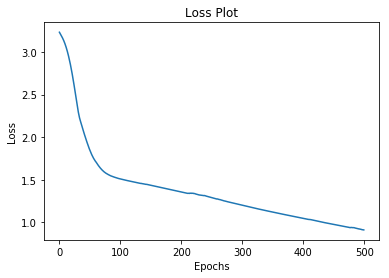

In [40]:
import matplotlib.pyplot as plt
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [53]:
im, cap, name = dataset[11]

In [54]:
cap

tensor([   4,   21,  888,   54,    9,  495,  183,   26, 1913, 3090,    2,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0], dtype=torch.int16)

In [55]:
im = im.unsqueeze(0)
cap = cap.unsqueeze(0)
name

'extracted_data/train/vecs/COCO_train2014_000000299675'

In [56]:
im.shape

torch.Size([1, 64, 2048])

In [57]:
train_vocab.decode_sentence(cap.tolist()[0])

'a white square kitchen with tile floor that needs repairs <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [58]:
model.eval()

out = model.evaluate(im)
out

['a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man',
 'and',
 'a',
 'man']

In [48]:
cap.shape

torch.Size([1, 50])

## Other images

In [49]:
img = preprocess_image_web('https://scontent.fbeg1-1.fna.fbcdn.net/v/t1.15752-9/106495264_270801397340750_5352596102031662927_n.jpg?_nc_cat=111&_nc_sid=b96e70&_nc_eui2=AeHUk7NrGbTNGQAAWPZuOseGdyXefbU8isZ3Jd59tTyKxlrvw8eGUmMqySImBZ4oCy2B2dfMEUR0-VKmJ7nQm1EF&_nc_ohc=f6VChx9r9cEAX_nfj3j&_nc_ht=scontent.fbeg1-1.fna&oh=7f53e6371c6af62fed5640d62a8df943&oe=5F225805')

In [50]:
img = preprocess_image_web('https://cdn.vox-cdn.com/thumbor/vQ_TbE_e04tsWLhQqMCG40Nn33o=/0x0:600x450/1200x900/filters:focal(0x0:600x450):no_upscale()/cdn.vox-cdn.com/uploads/chorus_asset/file/19650209/Kitchen_0719-Brookline_Shot7A-Kitchen_StraightOnFromDiningArea-27.0.0.jpg')

In [51]:
# img = preprocess_image('mscoco/train/img/COCO_train2014_000000028149')

In [52]:
img = img.reshape(1,64,2048)

In [53]:
out = model.evaluate(img)
out

['a',
 'very',
 'clean',
 'and',
 'well',
 'decorated',
 'empty',
 'bathroom',
 '<end>']